# Technical pattern screener and analysis

Framework from [this quantopian thread](https://www.quantopian.com/posts/an-empirical-algorithmic-evaluation-of-technical-analysis).

Go to [Running screener](#runningscreener) section for instructions on how to run.

In [24]:
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
from collections import defaultdict
import warnings
import time
import matplotlib.pyplot as plt
import matplotlib
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'
from tqdm import tqdm

import alpaca_trade_api as tradeapi

api = tradeapi.REST('API KEY HERE',
                    'API SECRET CODE HERE', 
                    'https://paper-api.alpaca.markets')

from datetime import timedelta

matplotlib.rcParams['figure.figsize'] = (8, 5)

In [3]:
def get_data(symbol, lookback):
    all_data = pd.DataFrame()
    for x in range(lookback):
        if x == 0:
            data = api.polygon.historic_agg('minute', 
                                            symbol, 
                                            limit=None).df
        else:
            data = api.polygon.historic_agg('minute', 
                                        symbol, 
                                        _from = (data.index.min() - timedelta(days=5)).strftime('%x %X'),
                                        to = start, 
                                        limit = None).df
        start = data.index.min().strftime('%x %X')
        all_data = pd.concat([data, all_data], axis=0)
    all_data.drop(columns=['volume'], inplace=True)
    all_data.replace(0, method='bfill', inplace=True)
    return all_data
        
def get_stock_data(stocklist, lookback):
    stock_data = {}
    for stock in tqdm(stocklist, desc='Getting stock data'):
        try:
            stock_data[stock] = get_data(stock, lookback)
        except Exception as e:
            print('Exception {} {}'.format(stock, e))
    return stock_data

def resample(stock_data, rate):
    for stock in stock_data:
        stock_data[stock] = stock_data[stock].resample(rate, closed='right', label='right').agg({'open': 'first',
                                                                                                 'high': 'max',
                                                                                                 'low': 'min',
                                                                                                 'close': 'last'}).dropna()
    return stock_data

def get_max_min(prices, smoothing, window_range):
    smooth_prices = prices['close'].rolling(window=smoothing).mean().dropna()
    local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    price_local_max_dt = []
    for i in local_max:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_max_dt.append(prices.iloc[i-window_range:i+window_range]['close'].idxmax())
    price_local_min_dt = []
    for i in local_min:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_min_dt.append(prices.iloc[i-window_range:i+window_range]['close'].idxmin())  
    maxima = pd.DataFrame(prices.loc[price_local_max_dt])
    minima = pd.DataFrame(prices.loc[price_local_min_dt])
    max_min = pd.concat([maxima, minima]).sort_index()
    max_min.index.name = 'date'
    max_min = max_min.reset_index()
    max_min = max_min[~max_min.date.duplicated()]
    p = prices.reset_index()   
    max_min['day_num'] = p[p['timestamp'].isin(max_min.date)].index.values
    max_min = max_min.set_index('day_num')['close']
    
    return max_min

def find_patterns(max_min):  
    patterns = defaultdict(list)
    
    for i in range(5, len(max_min)):  
        window = max_min.iloc[i-5:i]
        
        # Pattern must play out in less than n units
        if window.index[-1] - window.index[0] > 100:      
            continue   
            
        a, b, c, d, e = window.iloc[0:5]
                
        # IHS
        if a<b and c<a and c<e and c<d and e<d and abs(b-d)<=np.mean([b,d])*0.02:
               patterns['IHS'].append((window.index[0], window.index[-1]))
        
    return patterns
    
def plot_minmax_patterns(prices, max_min, patterns, stock, window, ema):
    
    incr = str((prices.index[1] - prices.index[0]).seconds/60)
    
    if len(patterns) == 0:
        pass
    else:
        num_pat = len([x for x in patterns.items()][0][1])
        f, axes = plt.subplots(1, 2, figsize=(16, 5))
        axes = axes.flatten()
        prices_ = prices.reset_index()['close']
        axes[0].plot(prices_)
        axes[0].scatter(max_min.index, max_min, s=100, alpha=.3, color='orange')
        axes[1].plot(prices_)
        for name, end_day_nums in patterns.items():
            for i, tup in enumerate(end_day_nums):
                sd = tup[0]
                ed = tup[1]
                axes[1].scatter(max_min.loc[sd:ed].index,
                              max_min.loc[sd:ed].values,
                              s=200, alpha=.3)
                plt.yticks([])
        plt.tight_layout()
        plt.title('{}: {}: EMA {}, Window {} ({} patterns)'.format(stock, incr, ema, window, num_pat))

def get_results(prices, max_min, pat, stock, ema_, window_):
    
    incr = str((prices.index[1] - prices.index[0]).seconds/60)
    
    #fw_list = [1, 12, 24, 36] 
    fw_list = [1, 2, 3]
    results = []
    if len(pat.items()) > 0:
        end_dates = [v for k, v in pat.items()][0]      
        for date in end_dates:  
            param_res = {'stock': stock,
                         'increment': incr,
                         'ema': ema_,
                         'window': window_, 
                         'date': date}
            for x in fw_list:
                returns = (prices['close'].pct_change(x).shift(-x).reset_index(drop=True).dropna())
                try:
                    param_res['fw_ret_{}'.format(x)] = returns.loc[date[1]]   
                except Exception as e:
                    param_res['fw_ret_{}'.format(x)] = e
            results.append(param_res)  
    else:
        param_res = {'stock': stock,
                     'increment': incr,
                     'ema': ema_,
                     'window': window_,
                     'date': None}
        for x in fw_list:
            param_res['fw_ret_{}'.format(x)] = None   
        results.append(param_res)
    return pd.DataFrame(results)

def screener(stock_data, ema_list, window_list, plot, results):
    
    all_results = pd.DataFrame()
    
    for stock in stock_data:
        prices = stock_data[stock]
        
        for ema_ in ema_list:
            for window_ in window_list: 
                max_min = get_max_min(prices, smoothing=ema_, window_range=window_)
                pat = find_patterns(max_min)
                
                if plot == True:
                    plot_minmax_patterns(prices, max_min, pat, stock, window_, ema_)
                    
                if results == True:
                    all_results = pd.concat([all_results, get_results(prices, max_min, pat, stock, ema_, window_)], axis=0)
                
    if results == True:
        return all_results.reset_index(drop=True)

<a id='runningscreener'></a>

# Running screener

By default, get_stock_data() gets 1 minute data. 

resampled_stock_data is run in a separate cell, so you can go back and get different timeframes without requesting data repeatedly. Timeframe is specified in resample() (see comment for details).

screener() actually runs the screener. Set plot=True to see plots, otherwise results=True outputs results. To get results as an object, you have to set it to a variable (example cell below).

In [17]:
stocklist = ['TWTR', 'MSFT','MMM',
             'S', 'V', 'VZ', 'AAPL', 
             'AMZN', 'FB', 'NFLX', 
             'GOOG', 'GS', 'LNKD',
             'TLRY']

stock_data = get_stock_data(stocklist, 5)

Getting stock data: 100%|██████████| 14/14 [00:20<00:00,  1.36s/it]


In [21]:
# Run different timeframes here without requesting new data. '5T' = 5 minutes, '60T' = 1 hour, '120T' = 2 hours, etc.
resampled_stock_data = resample(stock_data, '360T')

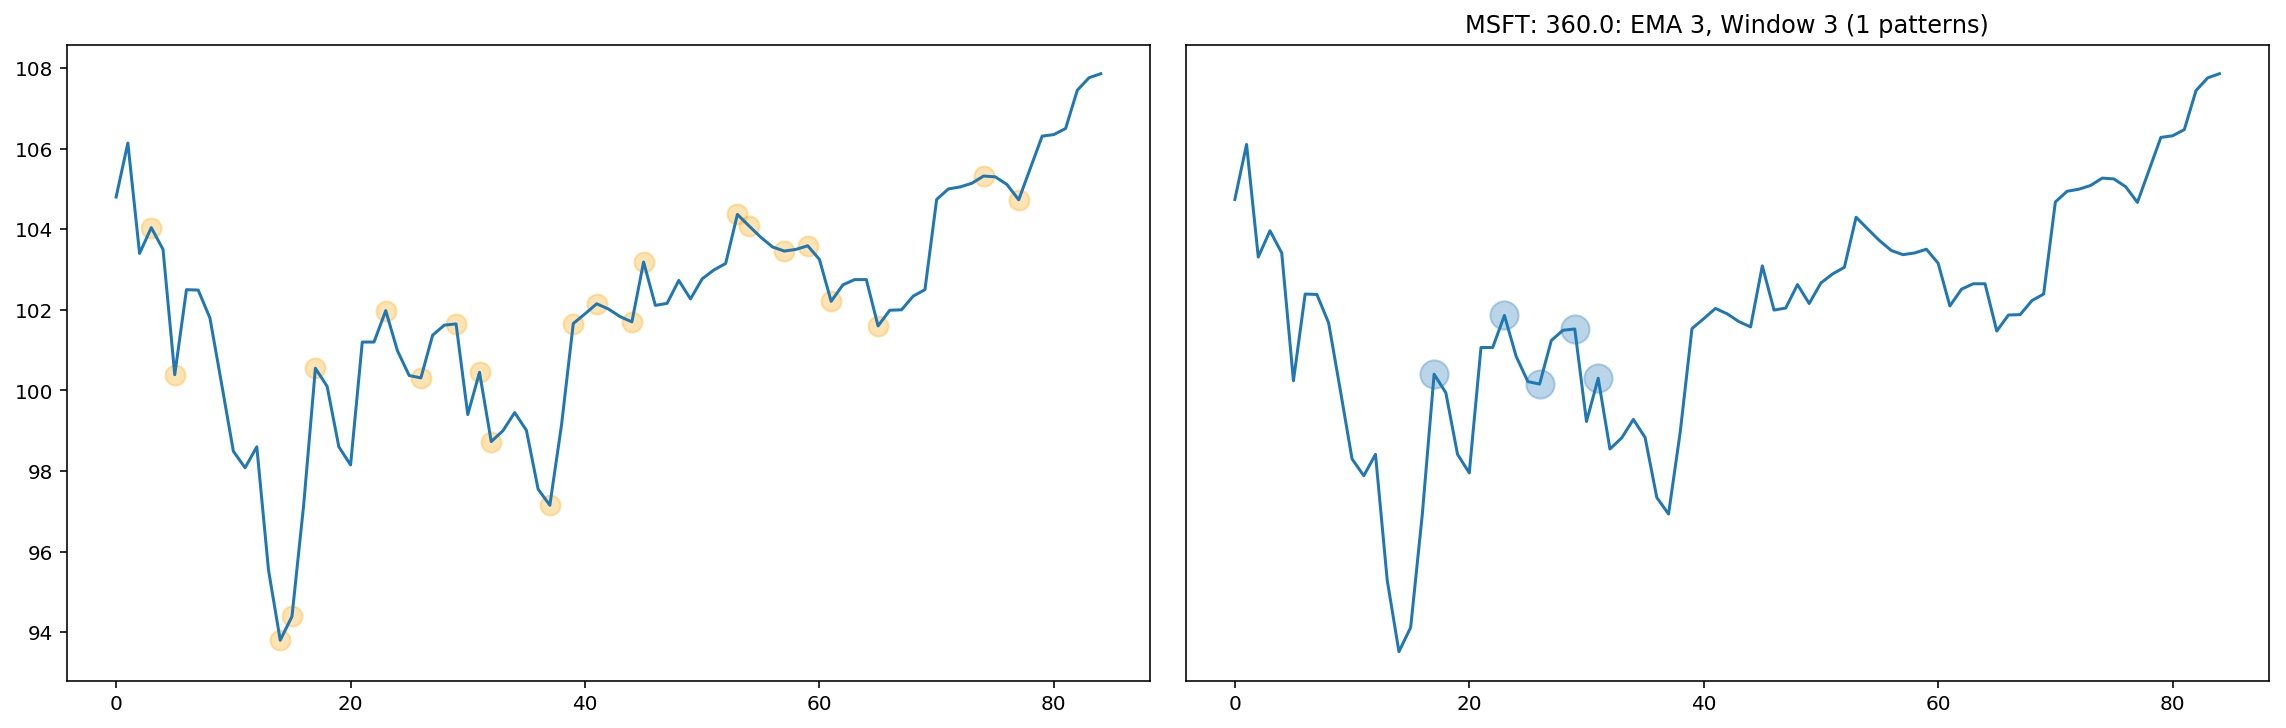

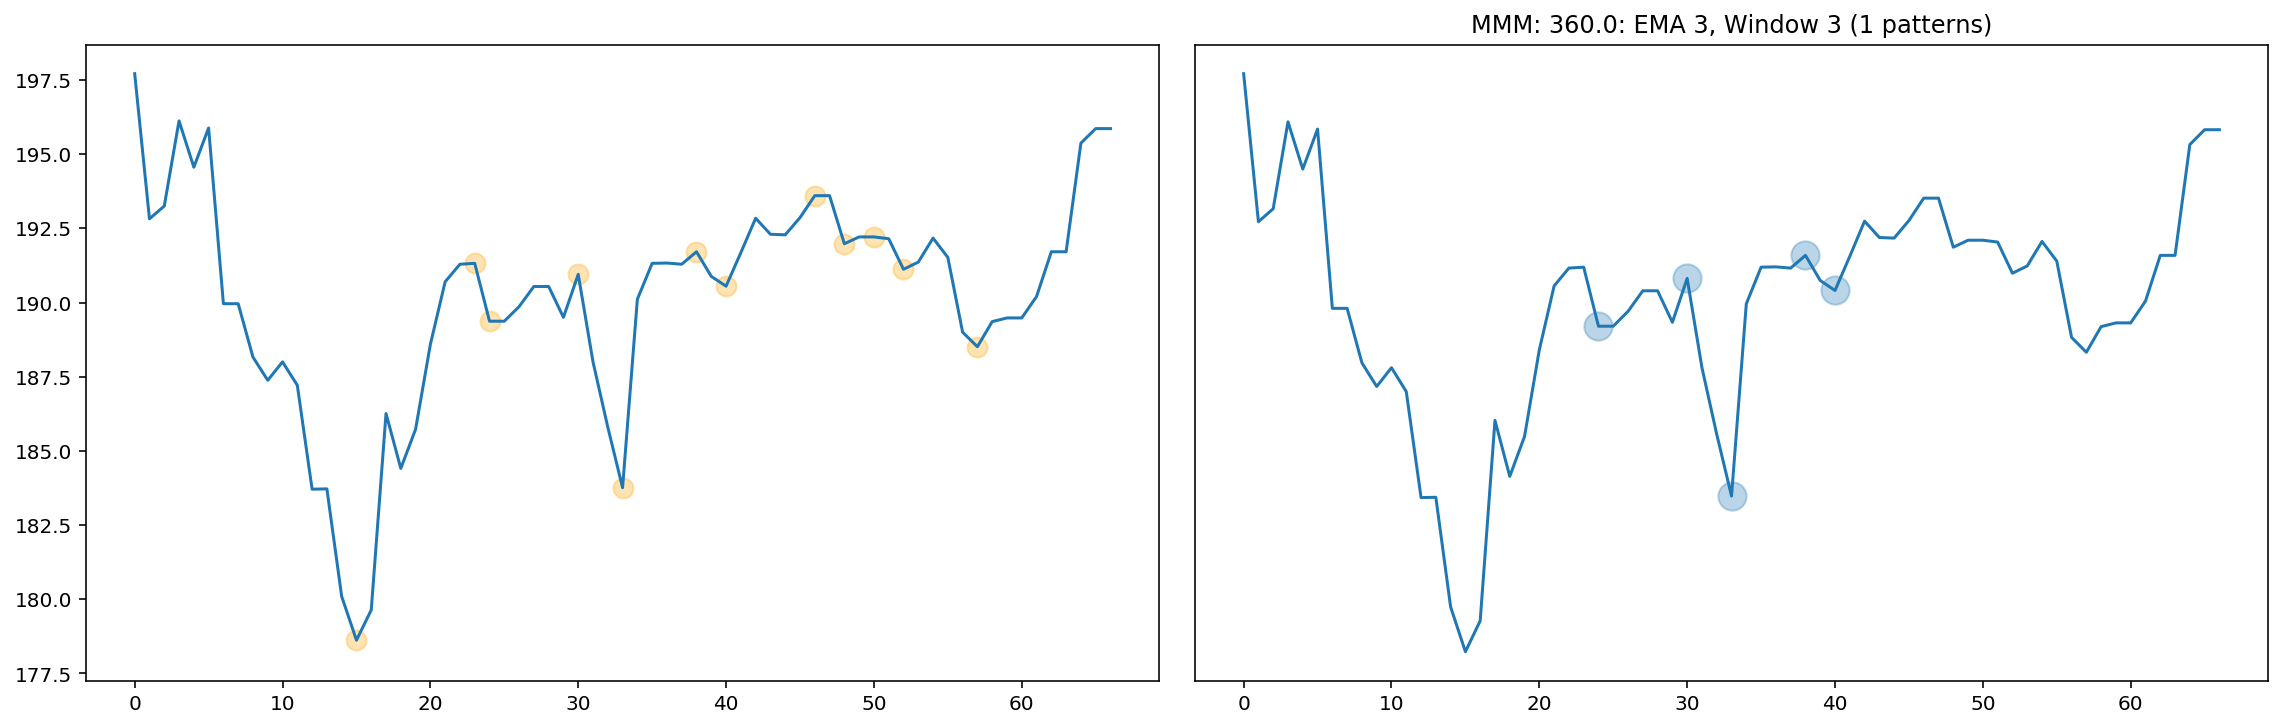

In [22]:
# Run the screener on ema_list and window_list, plotting results.

ema_list = [3, 10, 20, 30, ]
window_list = [3, 10, 20, 30, ]

results = screener(resampled_stock_data, ema_list, window_list, plot=True, results=True)

In [23]:
# Examples of reading the results.

for x in [x for x in results.columns if x not in ['stock', 'date']]:
    results[x] = pd.to_numeric(results[x], errors='coerce')
    
print('Average results by window param')
display(round(results.groupby('window').mean(), 3).sort_values(by=[x for x in results.columns if 'fw' in x], ascending=False))
print('\n', 'Average results by ema param')
display(round(results.groupby('ema').mean(), 3).sort_values(by=[x for x in results.columns if 'fw' in x], ascending=False))
print('\n', 'Average results by stock')
display(round(results.groupby('stock').mean(), 3).sort_values(by=[x for x in results.columns if 'fw' in x], ascending=False))
# print('\n', 'Results sorted by return')
# display(round(results.sort_values(by=[x for x in results.columns if 'fw' in x], ascending=False), 3))

Average results by window param


,ema,fw_ret_1,fw_ret_2,fw_ret_3,increment
window,,,,,
3,15.75,-0.006,-0.001,-0.0,360.0
10,15.75,NaN,NaN,NaN,360.0
20,15.75,NaN,NaN,NaN,360.0
30,15.75,NaN,NaN,NaN,360.0



 Average results by ema param


,fw_ret_1,fw_ret_2,fw_ret_3,increment,window
ema,,,,,
3,-0.006,-0.001,-0.0,360.0,15.75
10,NaN,NaN,NaN,360.0,15.75
20,NaN,NaN,NaN,360.0,15.75
30,NaN,NaN,NaN,360.0,15.75



 Average results by stock


,ema,fw_ret_1,fw_ret_2,fw_ret_3,increment,window
stock,,,,,,
MMM,15.75,0.006,0.012,0.009,360.0,15.75
MSFT,15.75,-0.017,-0.014,-0.010,360.0,15.75
AAPL,15.75,NaN,NaN,NaN,360.0,15.75
AMZN,15.75,NaN,NaN,NaN,360.0,15.75
FB,15.75,NaN,NaN,NaN,360.0,15.75
GOOG,15.75,NaN,NaN,NaN,360.0,15.75
GS,15.75,NaN,NaN,NaN,360.0,15.75
LNKD,15.75,NaN,NaN,NaN,360.0,15.75
NFLX,15.75,NaN,NaN,NaN,360.0,15.75


In [ ]:
# Saves to .csv for later
# results.to_csv('./tech_patterns_results_7.csv')